<a href="https://colab.research.google.com/github/ilham-mukti/Mencoba-Neural-Network/blob/main/Latihan_Neural_Network_Gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install jcopdl
!pip install jcopml

  Created wheel for jcopdl: filename=jcopdl-1.1.9-py2.py3-none-any.whl size=16925 sha256=04a0daa1ff07552f7ee9688be12f0e4579778274a93e62eb25cc972f6f1fec48
  Stored in directory: /root/.cache/pip/wheels/bb/fd/9d/fc72bcf569000eabd487e654fdf55b587e66882b60eaa5693b
Successfully built jcopdl
     |████████████████████████████████| 102kB 5.9MB/s 
  Created wheel for jcopml: filename=jcopml-1.1.10-py2.py3-none-any.whl size=33230 sha256=ef79548592c64ca41422b7a804402995eb5598f7b24770013abbc5afa03cca2c
  Stored in directory: /root/.cache/pip/wheels/82/22/ce/b8b4c3400f788e5050b5b4b4d988884b8ec72b6b8751693914
Successfully built jcopml


In [5]:
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm
from jcopdl.callback import Callback, set_config
from jcopdl.layers import linear_block

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import pandas as pd
import numpy as np

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.feature_importance import mean_score_decrease
from jcopml.plot import plot_missing_value, plot_confusion_matrix, plot_correlation_matrix

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [14]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.Grayscale(),
                                transforms.ToTensor(),
                                #transforms.Normalize((0.5, ), (0.5,))
                                ])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=True, num_workers=2)

In [16]:
class FashionClassifier(nn.Module):
  def __init__(self, input_size, n1, n2, output_size, dropout=0.2):
    super().__init__()
    self.fc = nn.Sequential(
        nn.Flatten(),
        linear_block(input_size, n1, dropout=dropout),
        linear_block(n1, n2, dropout=dropout),
        linear_block(n2, output_size, activation='lsoftmax')
    )

  def forward(self, x):
    return self.fc(x)

In [22]:
config = set_config({
    "input_size": 784,
    "n1": 256,
    "n2": 64,
    "output_size": len(trainset.classes),
    "dropout": 0.4
})

In [23]:
len(trainset.classes)

10

In [24]:
model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir='model')

In [25]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == 'train':
    model.train()
  elif mode == 'test':
    model.eval()
  
  cost = correct = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output = model(feature)
    loss = criterion(output, target)

    if mode == 'train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    cost += loss.item() * feature.shape[0]
    correct += (output.argmax(1) == target).sum().item()
  cost = cost/len(dataset)
  acc = correct/len(dataset)
  return cost, acc



Epoch     1
Train_cost  = 0.7369 | Test_cost  = 0.4689 | Train_score = 0.7407 | Test_score = 0.8292 |




Epoch     2
Train_cost  = 0.4854 | Test_cost  = 0.4205 | Train_score = 0.8314 | Test_score = 0.8438 |




Epoch     3
Train_cost  = 0.4371 | Test_cost  = 0.3972 | Train_score = 0.8456 | Test_score = 0.8569 |




Epoch     4
Train_cost  = 0.4108 | Test_cost  = 0.3750 | Train_score = 0.8555 | Test_score = 0.8652 |




Epoch     5
Train_cost  = 0.3923 | Test_cost  = 0.3783 | Train_score = 0.8606 | Test_score = 0.8653 |




Epoch     6
Train_cost  = 0.3779 | Test_cost  = 0.3656 | Train_score = 0.8640 | Test_score = 0.8678 |




Epoch     7
Train_cost  = 0.3667 | Test_cost  = 0.3555 | Train_score = 0.8692 | Test_score = 0.8712 |




Epoch     8
Train_cost  = 0.3598 | Test_cost  = 0.3561 | Train_score = 0.8711 | Test_score = 0.8684 |
==> EarlyStop patience =  1 | Best test_score: 0.8712




Epoch     9
Train_cost  = 0.3505 | Test_cost  = 0.3458 | Train_score = 0.8736 | Test_score = 0.8731 |




Epoch    10
Train_cost  = 0.3432 | Test_cost  = 0.3391 | Train_score = 0.8777 | Test_score = 0.8786 |




Epoch    11
Train_cost  = 0.3365 | Test_cost  = 0.3403 | Train_score = 0.8788 | Test_score = 0.8770 |
==> EarlyStop patience =  1 | Best test_score: 0.8786




Epoch    12
Train_cost  = 0.3313 | Test_cost  = 0.3317 | Train_score = 0.8800 | Test_score = 0.8797 |




Epoch    13
Train_cost  = 0.3294 | Test_cost  = 0.3354 | Train_score = 0.8807 | Test_score = 0.8821 |




Epoch    14
Train_cost  = 0.3199 | Test_cost  = 0.3462 | Train_score = 0.8863 | Test_score = 0.8775 |
==> EarlyStop patience =  1 | Best test_score: 0.8821




Epoch    15
Train_cost  = 0.3160 | Test_cost  = 0.3317 | Train_score = 0.8859 | Test_score = 0.8797 |
==> EarlyStop patience =  2 | Best test_score: 0.8821




Epoch    16
Train_cost  = 0.3125 | Test_cost  = 0.3322 | Train_score = 0.8857 | Test_score = 0.8818 |
==> EarlyStop patience =  3 | Best test_score: 0.8821




Epoch    17
Train_cost  = 0.3097 | Test_cost  = 0.3314 | Train_score = 0.8869 | Test_score = 0.8779 |
==> EarlyStop patience =  4 | Best test_score: 0.8821




Epoch    18
Train_cost  = 0.3039 | Test_cost  = 0.3242 | Train_score = 0.8882 | Test_score = 0.8852 |




Epoch    19
Train_cost  = 0.3018 | Test_cost  = 0.3181 | Train_score = 0.8903 | Test_score = 0.8862 |




Epoch    20
Train_cost  = 0.2971 | Test_cost  = 0.3267 | Train_score = 0.8923 | Test_score = 0.8819 |


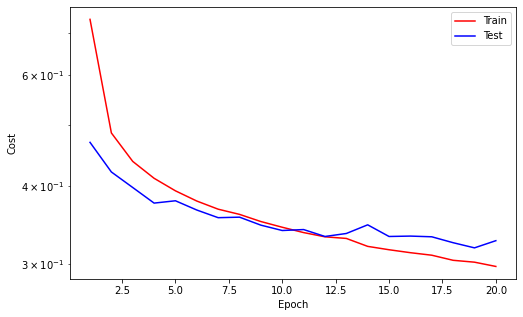

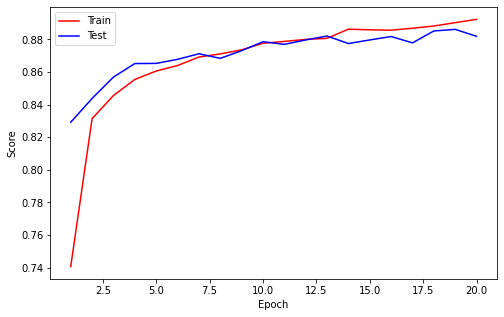

==> EarlyStop patience =  1 | Best test_score: 0.8862




Epoch    21
Train_cost  = 0.2973 | Test_cost  = 0.3252 | Train_score = 0.8909 | Test_score = 0.8851 |
==> EarlyStop patience =  2 | Best test_score: 0.8862




Epoch    22
Train_cost  = 0.2933 | Test_cost  = 0.3176 | Train_score = 0.8918 | Test_score = 0.8854 |
==> EarlyStop patience =  3 | Best test_score: 0.8862




Epoch    23
Train_cost  = 0.2895 | Test_cost  = 0.3179 | Train_score = 0.8927 | Test_score = 0.8860 |
==> EarlyStop patience =  4 | Best test_score: 0.8862




Epoch    24
Train_cost  = 0.2851 | Test_cost  = 0.3178 | Train_score = 0.8946 | Test_score = 0.8867 |




Epoch    25
Train_cost  = 0.2861 | Test_cost  = 0.3308 | Train_score = 0.8940 | Test_score = 0.8866 |
==> EarlyStop patience =  1 | Best test_score: 0.8867




Epoch    26
Train_cost  = 0.2831 | Test_cost  = 0.3195 | Train_score = 0.8960 | Test_score = 0.8896 |




Epoch    27
Train_cost  = 0.2800 | Test_cost  = 0.3140 | Train_score = 0.8968 | Test_score = 0.8872 |
==> EarlyStop patience =  1 | Best test_score: 0.8896




Epoch    28
Train_cost  = 0.2795 | Test_cost  = 0.3299 | Train_score = 0.8965 | Test_score = 0.8817 |
==> EarlyStop patience =  2 | Best test_score: 0.8896




Epoch    29
Train_cost  = 0.2755 | Test_cost  = 0.3203 | Train_score = 0.8988 | Test_score = 0.8896 |
==> EarlyStop patience =  3 | Best test_score: 0.8896




Epoch    30
Train_cost  = 0.2745 | Test_cost  = 0.3149 | Train_score = 0.9009 | Test_score = 0.8907 |




Epoch    31
Train_cost  = 0.2726 | Test_cost  = 0.3165 | Train_score = 0.8988 | Test_score = 0.8894 |
==> EarlyStop patience =  1 | Best test_score: 0.8907




Epoch    32
Train_cost  = 0.2682 | Test_cost  = 0.3180 | Train_score = 0.9006 | Test_score = 0.8876 |
==> EarlyStop patience =  2 | Best test_score: 0.8907




Epoch    33
Train_cost  = 0.2684 | Test_cost  = 0.3176 | Train_score = 0.9005 | Test_score = 0.8925 |




Epoch    34
Train_cost  = 0.2650 | Test_cost  = 0.3183 | Train_score = 0.9026 | Test_score = 0.8905 |
==> EarlyStop patience =  1 | Best test_score: 0.8925




Epoch    35
Train_cost  = 0.2649 | Test_cost  = 0.3127 | Train_score = 0.9014 | Test_score = 0.8939 |




Epoch    36
Train_cost  = 0.2635 | Test_cost  = 0.3214 | Train_score = 0.9030 | Test_score = 0.8897 |
==> EarlyStop patience =  1 | Best test_score: 0.8939




Epoch    37
Train_cost  = 0.2612 | Test_cost  = 0.3202 | Train_score = 0.9035 | Test_score = 0.8907 |
==> EarlyStop patience =  2 | Best test_score: 0.8939




Epoch    38
Train_cost  = 0.2630 | Test_cost  = 0.3228 | Train_score = 0.9028 | Test_score = 0.8871 |
==> EarlyStop patience =  3 | Best test_score: 0.8939




Epoch    39
Train_cost  = 0.2582 | Test_cost  = 0.3133 | Train_score = 0.9049 | Test_score = 0.8915 |
==> EarlyStop patience =  4 | Best test_score: 0.8939




Epoch    40
Train_cost  = 0.2580 | Test_cost  = 0.3102 | Train_score = 0.9044 | Test_score = 0.8925 |


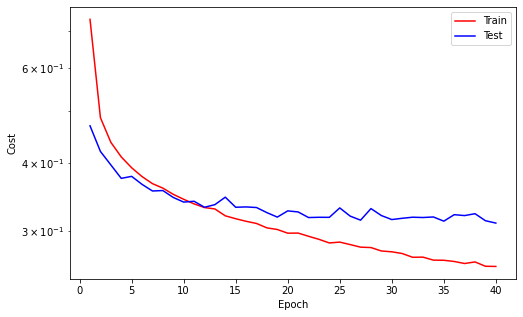

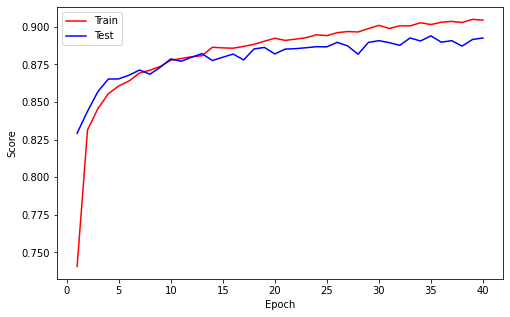

==> EarlyStop patience =  5 | Best test_score: 0.8939
==> Execute Early Stopping at epoch: 40 | Best test_score: 0.8939
==> Best model is saved at model


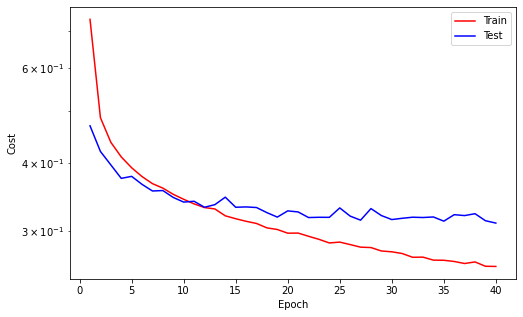

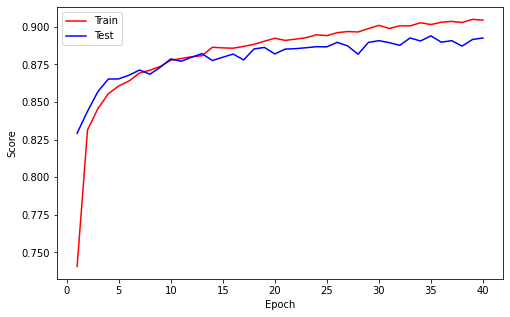

In [26]:
while True:
  train_cost, train_score = loop_fn('train', trainset, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('test', testset, testloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break